<a href="https://colab.research.google.com/github/nicolasdagosta/LSTM/blob/main/LSTM_MORA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
%matplotlib inline

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/11qRxfVUcq5iD6QgkeOoPZQvqWepTe1WJ/view?usp=sharing' # The shareable link

fileDownloaded = drive.CreateFile({'id':'11qRxfVUcq5iD6QgkeOoPZQvqWepTe1WJ'})
fileDownloaded.GetContentFile('pied_fc_llam_20210520_b.csv')
stock_data = pd.read_csv('pied_fc_llam_20210520_b.csv', delimiter=';' )

In [ ]:
lookback= 60
ventana_prediccion=lookback
test_size=int(.3 * (len(stock_data)-lookback-ventana_prediccion))

In [ ]:
stock_data.sort_values(by=['ds'], inplace=True, ascending=False)
#stock_data=stock_data[stock_data["FL_LABORAL"]==1]
stock_data['lag_NRO_DIA_LABORAL']=stock_data['NRO_DIA_LABORAL'].shift(lookback)
stock_data['lag_CANT_DIAS_LABORALES']=stock_data['CANT_DIAS_LABORALES'].shift(lookback)
stock_data['lag_NRO_DIA_LABORAL_NAR']=stock_data['NRO_DIA_LABORAL_NAR'].shift(lookback)
stock_data['lag_NRO_SEMANA_NAR']=stock_data['NRO_SEMANA_NAR'].shift(lookback)
stock_data['lag_FL_LABORAL']=stock_data['FL_LABORAL'].shift(lookback)
stock_data.head(10)

,ds,y,FL_LABORAL,PERIODO,CANT_DIAS_LABORALES,NRO_DIA_LABORAL,NRO_DIA_LABORAL_NAR,NRO_SEMANA_NAR,PARTICIPACION,CANT_CLIENTES_MORA,CANT_CLIENTES_VTO,CANT_CUENTAS_NPLUS,CANT_CUENTAS_PC,CANT_CUENTAS_PP,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,y_11,y_12,LAGGED_mean,LAGGED_std,LAGGED_var_ia,lag_NRO_DIA_LABORAL,lag_CANT_DIAS_LABORALES,lag_NRO_DIA_LABORAL_NAR,lag_NRO_SEMANA_NAR,lag_FL_LABORAL
499,2021-04-30,3303,1,2021-04-01,21,21.0,5.0,1,8.159988,251217.0,2566774.0,310785.0,46466.0,12840.0,4062.0,569.0,3674.0,623.0,1891.0,3503.0,3237.0,1708.0,1192.0,2194.0,2853.0,5408.0,2576.166667,1475.043595,0.522482,NaN,NaN,NaN,NaN,NaN
498,2021-04-29,3819,1,2021-04-01,21,20.0,4.0,1,9.434755,251217.0,2566774.0,310785.0,46466.0,12840.0,5658.0,569.0,3674.0,623.0,1891.0,4075.0,3312.0,1708.0,1507.0,2663.0,2853.0,5810.0,2861.916667,1738.932978,0.053111,NaN,NaN,NaN,NaN,NaN
497,2021-04-28,4502,1,2021-04-01,21,19.0,3.0,1,11.122091,251217.0,2566774.0,310785.0,46466.0,12840.0,617.0,569.0,3392.0,2021.0,2453.0,5657.0,728.0,1982.0,1910.0,690.0,3812.0,6319.0,2512.500000,1944.810133,2.269453,NaN,NaN,NaN,NaN,NaN
496,2021-04-27,2220,1,2021-04-01,21,18.0,2.0,1,5.484461,251217.0,2566774.0,310785.0,46466.0,12840.0,769.0,569.0,1549.0,2493.0,747.0,3362.0,690.0,1997.0,2327.0,707.0,4827.0,2039.0,1839.666667,1300.855686,0.690342,NaN,NaN,NaN,NaN,NaN
495,2021-04-26,790,1,2021-04-01,21,17.0,1.0,1,1.951677,251217.0,2566774.0,310785.0,46466.0,12840.0,719.0,551.0,512.0,4832.0,861.0,905.0,952.0,430.0,2439.0,905.0,1151.0,2217.0,1372.833333,1260.377276,1.091174,NaN,NaN,NaN,NaN,NaN
494,2021-04-23,892,1,2021-04-01,21,16.0,20.0,5,2.203666,251217.0,2566774.0,310785.0,46466.0,12840.0,919.0,692.0,490.0,200.0,1005.0,692.0,871.0,496.0,577.0,1042.0,45.0,2446.0,789.583333,604.483470,1.933931,NaN,NaN,NaN,NaN,NaN
493,2021-04-22,894,1,2021-04-01,21,15.0,19.0,4,2.208607,251217.0,2566774.0,310785.0,46466.0,12840.0,733.0,706.0,569.0,735.0,863.0,938.0,927.0,655.0,636.0,1164.0,1244.0,2626.0,983.000000,557.593368,1.925738,NaN,NaN,NaN,NaN,NaN
492,2021-04-21,1028,1,2021-04-01,21,14.0,18.0,4,2.539651,251217.0,2566774.0,310785.0,46466.0,12840.0,756.0,929.0,589.0,1359.0,752.0,1312.0,664.0,574.0,715.0,907.0,1286.0,3314.0,1096.416667,752.590128,2.333055,NaN,NaN,NaN,NaN,NaN
491,2021-04-20,835,1,2021-04-01,21,13.0,17.0,4,2.062849,251217.0,2566774.0,310785.0,46466.0,12840.0,893.0,934.0,658.0,1181.0,850.0,953.0,634.0,616.0,795.0,956.0,1424.0,2480.0,1031.166667,511.160148,1.539033,NaN,NaN,NaN,NaN,NaN
490,2021-04-19,1204,1,2021-04-01,21,12.0,16.0,4,2.974455,251217.0,2566774.0,310785.0,46466.0,12840.0,954.0,970.0,652.0,1156.0,879.0,927.0,642.0,653.0,841.0,1035.0,1532.0,3021.0,1105.166667,652.146781,1.870306,NaN,NaN,NaN,NaN,NaN


In [ ]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 499 to 0
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ds                       500 non-null    object 
 1   y                        500 non-null    int64  
 2   FL_LABORAL               500 non-null    int64  
 3   PERIODO                  500 non-null    object 
 4   CANT_DIAS_LABORALES      500 non-null    int64  
 5   NRO_DIA_LABORAL          500 non-null    float64
 6   NRO_DIA_LABORAL_NAR      500 non-null    float64
 7   NRO_SEMANA_NAR           500 non-null    int64  
 8   PARTICIPACION            500 non-null    float64
 9   CANT_CLIENTES_MORA       500 non-null    float64
 10  CANT_CLIENTES_VTO        500 non-null    float64
 11  CANT_CUENTAS_NPLUS       500 non-null    float64
 12  CANT_CUENTAS_PC          500 non-null    float64
 13  CANT_CUENTAS_PP          500 non-null    float64
 14  y_1                      5

In [ ]:
seleccionadas = [1,9,10,29,30,31,32,33]
#[1,9,10,6,5,2]
n_vars=len(seleccionadas)
input_feature= stock_data.iloc[:,seleccionadas].values
input_data = input_feature

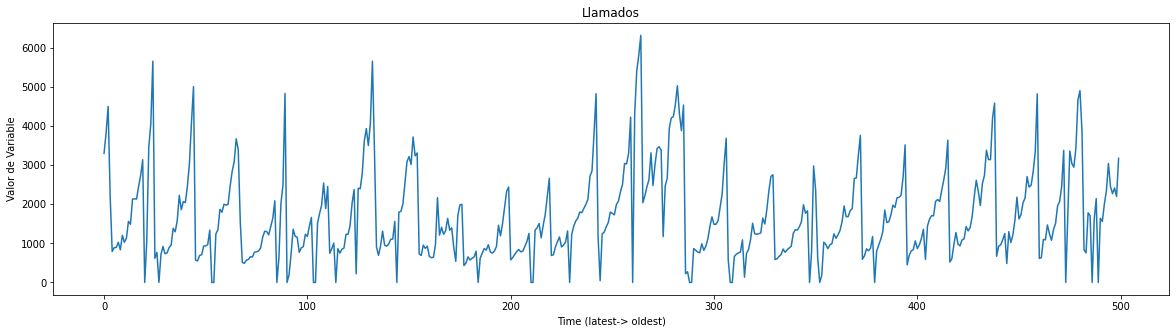

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(input_feature[:,0])
plt.title("Llamados")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Valor de Variable")
plt.show()

In [ ]:
#plt.plot(input_feature[:,2], color='blue')
#plt.title("Average Google Stock Prices")
#plt.xlabel("Time (latest-> oldest)")
#plt.ylabel("Stock Opening Price")
#plt.show()

In [ ]:
sc= MinMaxScaler(feature_range=(0,1))

input_data_train= input_feature[ (test_size+lookback+ventana_prediccion):,:]
input_data_train= input_feature[:(test_size+lookback+ventana_prediccion),:]

input_data_train = sc.fit_transform(input_feature[ (test_size+lookback+ventana_prediccion):,:])
input_data_test = sc.transform(input_feature[:(test_size+lookback+ventana_prediccion),:])

input_data= np.concatenate((input_data_test,input_data_train), axis=0)

In [ ]:
X=[]
y=[]

In [ ]:
for i in range(ventana_prediccion+1, len(stock_data)-lookback):
  #i va de 0 a 1209
  t=[]
  for j in range(0,lookback):
    t.append(input_data[[(i+j)], :])
  X.append(t)
 
  u=[]
  for k in range(0,ventana_prediccion): 
    u.append(input_data[[(i-(k+1))], 0])
  y.append(u)

In [ ]:
X, y= np.array(X), np.array(y)
X_train = X[test_size:]
X_test = X[0:test_size]

y_train=y[test_size:]
y_test=y[0:test_size]

X_train = X_train.reshape(X_train.shape[0],lookback, n_vars)
X_test = X_test.reshape(X_test.shape[0],lookback, n_vars)

y_train=  y_train.reshape(y_train.shape[0],ventana_prediccion)
y_test=  y_test.reshape(y_test.shape[0],ventana_prediccion)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(265, 60, 8)
(114, 60, 8)
(265, 60)
(114, 60)


In [ ]:
input_data[(ventana_prediccion+1+test_size)+1,:]

array([ 0.31603102, -0.39854533,  0.20151619,  0.60869565,  0.4       ,
        0.82608696,  0.75      ,  1.        ])

In [ ]:
y_train[0]

array([0.27029593, 0.08545656, 0.14195284, 0.22107928, 0.21158411,
       0.25921823, 0.20936857, 0.19512581, 0.22329483, 0.19132774,
       0.34309226, 0.1535053 , 0.10159835, 0.10033233, 0.10507992,
       0.14670043, 0.13783827, 0.15065675, 0.10919449, 0.1152081 ,
       0.52413357, 0.5122646 , 0.58870074, 0.47713246, 0.50925779,
       0.48884317, 0.40101282, 0.31761355, 0.28722899, 0.28453869,
       0.        , 0.24719101, 0.17550245, 0.17471119, 0.15524608,
       0.14670043, 0.150815  , 0.20762779, 0.14844121, 0.109511  ,
       0.14321886, 0.53204621, 0.89523659, 0.64488052, 0.55435987,
       0.62272511, 0.57208419, 0.4410508 , 0.37949043, 0.38107295,
       0.03497389, 0.37585061, 0.32093686, 0.2300997 , 0.19496756,
       0.1944928 , 0.13910429, 0.13451495, 0.11900617, 0.13657224])

In [ ]:
X_train[0]

array([[ 0.31365722, -0.39854533,  0.20151619,  0.65217391,  0.4       ,
         0.86956522,  0.75      ,  1.        ],
       [ 0.31603102, -0.39854533,  0.20151619,  0.60869565,  0.4       ,
         0.82608696,  0.75      ,  1.        ],
       [ 0.06804874, -0.39854533,  0.20151619,  0.56521739,  0.4       ,
         0.7826087 ,  0.75      ,  1.        ],
       [ 0.07849343, -0.39854533,  0.20151619,  0.52173913,  0.4       ,
         0.73913043,  0.75      ,  1.        ],
       [ 0.10365564, -0.39854533,  0.20151619,  0.47826087,  0.4       ,
         0.69565217,  0.75      ,  1.        ],
       [ 0.09083716, -0.39854533,  0.20151619,  0.43478261,  0.4       ,
         0.65217391,  0.5       ,  1.        ],
       [ 0.09748378, -0.39854533,  0.20151619,  0.39130435,  0.4       ,
         0.60869565,  0.5       ,  1.        ],
       [ 0.10333914, -0.39854533,  0.20151619,  0.34782609,  0.4       ,
         0.56521739,  0.5       ,  1.        ],
       [ 0.1262858 , -0.39854533

In [ ]:
 
from tensorflow.keras import backend as K
 
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(units=64*2*2*2 , recurrent_activation='sigmoid'  ,return_sequences= True, input_shape=(X.shape[1],n_vars)))
#model.add(LSTM(units=32*2*2*2, activation='relu',return_sequences=True))
model.add(LSTM(units=16*2*2))
model.add(Dense(units=ventana_prediccion))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 512)           1067008   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense (Dense)                (None, 60)                3900      
Total params: 1,218,620
Trainable params: 1,218,620
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam'  
              , loss=root_mean_squared_error)

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
history_model = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_data=(X_test,y_test),verbose=1 ,callbacks=[reduce_lr]
                          )
#, shuffle=True

Epoch 1/20
27/27 [==============================] - 33s 562ms/step - loss: 0.2222 - val_loss: 0.1788
Epoch 2/20
27/27 [==============================] - 14s 520ms/step - loss: 0.1708 - val_loss: 0.1860
Epoch 3/20
27/27 [==============================] - 14s 525ms/step - loss: 0.1657 - val_loss: 0.1803
Epoch 4/20
27/27 [==============================] - 14s 521ms/step - loss: 0.1537 - val_loss: 0.1835
Epoch 5/20
27/27 [==============================] - 14s 517ms/step - loss: 0.1429 - val_loss: 0.2024
Epoch 6/20
27/27 [==============================] - 14s 522ms/step - loss: 0.1317 - val_loss: 0.2002
Epoch 7/20
27/27 [==============================] - 14s 519ms/step - loss: 0.1299 - val_loss: 0.2029
Epoch 8/20
27/27 [==============================] - 14s 522ms/step - loss: 0.1277 - val_loss: 0.1959
Epoch 9/20
27/27 [==============================] - 14s 520ms/step - loss: 0.1231 - val_loss: 0.1969
Epoch 10/20
27/27 [==============================] - 14s 522ms/step - loss: 0.1202 - val_lo

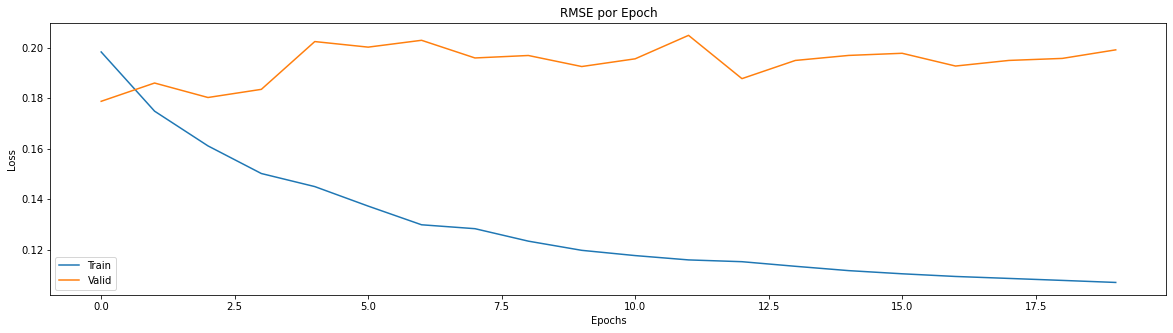

In [ ]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title("RMSE por Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
predicted_value= model.predict(X_test)


In [ ]:
predicted_value.shape

(114, 60)

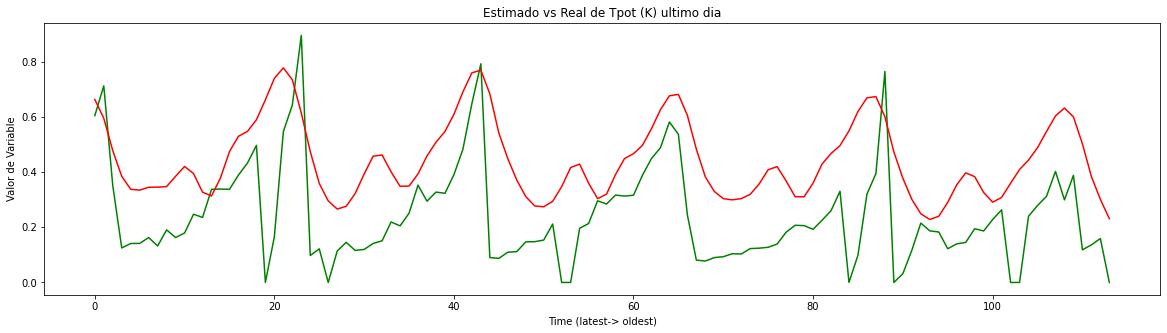

In [ ]:
dia=(ventana_prediccion-1)
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(y_test[:,dia], color='green')
plt.plot(predicted_value[:,dia], color= 'red')
plt.title("Estimado vs Real de Tpot (K) ultimo dia")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Valor de Variable")
plt.show()

In [ ]:
RMSE=(np.mean((y_test[:,dia] - predicted_value[:,dia])**2))**(1/2)
print("RMSE para el ultimo dia:", RMSE)

RMSE para el ultimo dia: 0.24620304743656785


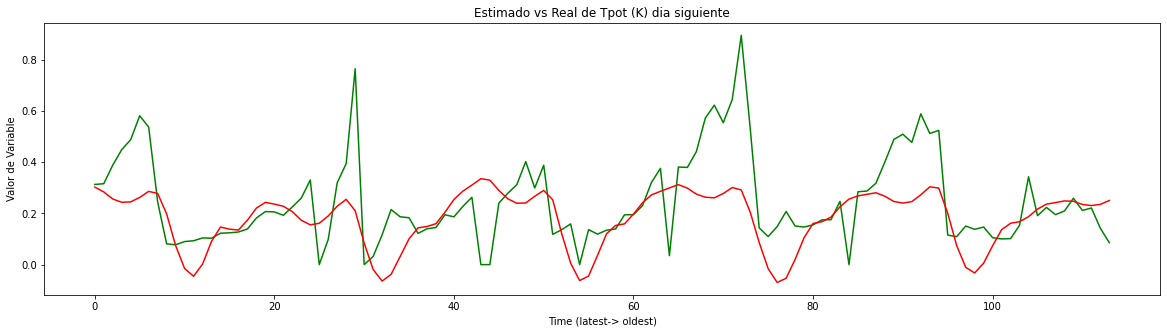

In [ ]:
dia=0
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(y_test[:,dia], color='green')
plt.plot(predicted_value[:,dia], color= 'red')
plt.title("Estimado vs Real de Tpot (K) dia siguiente")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Valor de Variable")
plt.show()

In [ ]:
RMSE=(np.mean((y_test[:,dia] - predicted_value[:,dia])**2))**(1/2)
print("RMSE para el dia siguiente:", RMSE)

RMSE para el dia siguiente: 0.16336295635810305
